In [1]:
Output = ('/Users/alexis/Library/CloudStorage/OneDrive-UniversityofNorthCarolinaatChapelHill/CEMALB_DataAnalysisPM/Projects/P1012. Allostatic Load/P1012.3. Analyses/P1012.3.2. Allostatic Load Calculation/Output')
cur_date = "062424"

library(readxl)
library(openxlsx)
library(tidyverse)
library(gtsummary)
library(ordinalNet)
library(reshape2)
library(rstatix)
library(car)
library(ggrepel)
library(ggsci)
library(cowplot)
library(ggpubr)
library(multcomp)
library(rlang)

# reading in file
bp_df = data.frame(read_excel("Input/Allostatic_Mediator_Data_050824.xlsx", sheet = 4)) 
subject_info_df = data.frame(read_excel("Input/Subject_Info_050824.xlsx", sheet = 2))
mediator_scores_df = data.frame(read_excel("Input/Mediator_Scores_061424.xlsx"))

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.3     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
#BlackLivesMatter


Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths



Attaching package: ‘rstatix’


The following object is masked from ‘package:stats’:

    filter



Attaching package: ‘cowplot’


The following object is masked from ‘package:lubridate’:

    stamp



Attaching package: ‘ggpubr’


The following object is masked from ‘package:cowplot’:

    get_legend


Loading required package: mvtnorm

Loading required 

In [2]:
head(bp_df)
head(subject_info_df)
head(mediator_scores_df)

,Subject_ID,Systolic,Diastolic,BP_Classification
,<chr>,<dbl>,<dbl>,<chr>
1,CS_M_21_W_5,114,70,N
2,CS_M_24_W_8,118,71,N
3,CS_M_25_W_10,121,83,E
4,CS_M_28_W_16,115,74,N
5,CS_M_29_W_17,118,80,N
6,CS_F_31_B_21,112,77,N


,Study,Original_Subject_Number,Subject_ID,Subject_Number,Smoking_Status,Sex,Age,Race
,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>
1,FM2,97,CS_M_18_B_1,1,CS,M,18,B
2,FM2,99,CS_F_20_W_2,2,CS,F,20,W
3,FM2,101,CS_F_20_W_3,3,CS,F,20,W
4,FM2,98,CS_F_21_W_4,4,CS,F,21,W
5,TCORS LAIV,39,CS_M_21_W_5,5,CS,M,21,W
6,FM2,100,CS_F_22_W_6,6,CS,F,22,W


,Variable,Subject_ID,Mediator_Score
,<chr>,<chr>,<dbl>
1,Cortisol,CS_M_18_B_1,0.4683470
2,Cortisol,CS_F_20_W_2,0.8342112
3,Cortisol,CS_F_20_W_3,0.1603803
4,Cortisol,CS_F_21_W_4,0.4583014
5,Cortisol,CS_M_21_W_5,0.3867217
6,Cortisol,CS_F_22_W_6,0.1712352


Calculating allostatic load (AL) scores for each subject, which serves as a measure for stress.

1. **Acute Stress**

    In this analysis, we're using [ordinal regression](https://www.statisticssolutions.com/free-resources/directory-of-statistical-analyses/ordinal-regression/) to predict blood pressure classification using mediator scores from 3 acute stress biomarkers (Noradrenaline, epinephrine, and cortisol).
    

3. **Chronic (secondary/tertiary) Stress**
   
    No deriving of ordinal weights in this analysis, since we don't have an outcome that we measured associated with chronic stress. We'll include 4 chronic stress biomarkers (CRP, Hba1c, Fibrnogen, and HDL). 
    

5. **Overall AL**
   
    Summing the acute and chronic AL scores.

# Acute Sress
Starting by combining the dataframes.

In [3]:
# creating a vector for variables that increase acute stress
acute_biomarkers = c('Cortisol','Noradrenaline','Epinephrine')

ordinal_regression = function(dataset){
    # add words!!!!!
    # creating 1 df
    ordinal_regression_df = inner_join(bp_df[,c(1,4)], subject_info_df[,3:8]) %>%
        # adding mediator scores data
        inner_join(dataset[,1:3]) %>%
        # obtaining acute biomarkers only
        filter(Variable %in% acute_biomarkers) %>%
        pivot_wider(names_from = Variable, values_from = Mediator_Score)

    #reordering and removing some columns
    ordinal_regression_df = ordinal_regression_df[,c(1,8:10,2)]

    return(ordinal_regression_df)
    }

# calling fn
reg_df = ordinal_regression(mediator_scores_df)

head(reg_df)

Joining with `by = join_by(Subject_ID)`
Joining with `by = join_by(Subject_ID)`


Subject_ID,Cortisol,Noradrenaline,Epinephrine,BP_Classification
<chr>,<dbl>,<dbl>,<dbl>,<chr>
CS_M_21_W_5,0.3867217,0.9216080,0.02133767,N
CS_M_24_W_8,0.4378417,0.5058597,0.02155180,N
CS_M_25_W_10,0.2932014,0.8479016,0.18657420,E
CS_M_28_W_16,0.2416750,0.5058597,0.48633181,N
CS_M_29_W_17,0.5472276,0.3352036,0.35658497,N
CS_F_31_B_21,0.3620846,0.2770528,0.16448963,N


## Assessing Distributions

Looking at the distributions of blood pressure classifications and the mediator scores for each variable.

In [4]:
table(reg_df$BP_Classification)


 1  2  E  N 
 6  1  9 18 

The stage 1 and stage 2 classes are on the smaller side with 6 and 1 subject, respectively. There weren't enough observation of the stage 2 class to perform SMOTE; therefore, the blood pressure classes will be condensed in two different ways:

+ **3 classes**: Normal subjects, at risk (elevated) subjects, and hypertensive subjects (formerly stage 1 and stage 2 subjects)
+ **2 classes**: Normal subjects and hypertensive subjects (formerly elevated, stage 1, and stage 2 subjects)

In [5]:
three_reg_df = reg_df %>%
    mutate(BP_Classification = ifelse(BP_Classification %in% c("1", "2"), "H", BP_Classification))

two_reg_df = reg_df %>%
    mutate(BP_Classification = ifelse(BP_Classification %in% c("1", "2", "E"), "H", BP_Classification))

# turning BP into a factor
three_reg_df$BP_Classification = factor(three_reg_df$BP_Classification, levels = c("N", "E", "H"))
two_reg_df$BP_Classification = factor(two_reg_df$BP_Classification, levels = c("N", "H"))

In [6]:
table(two_reg_df$BP_Classification)
table(three_reg_df$BP_Classification)


 N  H 
18 16 


 N  E  H 
18  9  7 

Now assessing normality of the biomarkers using a shapiro wilk test.

In [7]:
# using a shapiro wilk test to assess normality
do.call(rbind.data.frame, apply(reg_df[,2:4], 2, shapiro.test))[,1:3] %>%
    # adding a column that clarifies whether or not a variable is normally distributed or not
    mutate(Normality = ifelse(p.value < 0.05, "Non-normal", "Normal"))

,statistic,p.value,method,Normality
,<dbl>,<dbl>,<chr>,<chr>
Cortisol,0.7429965,2.411103e-06,Shapiro-Wilk normality test,Non-normal
Noradrenaline,0.9351777,4.436357e-02,Shapiro-Wilk normality test,Non-normal
Epinephrine,0.9389878,5.752138e-02,Shapiro-Wilk normality test,Normal


Only 1 variable was normally distributed; therefore, we'll perform a data transformation (pseudo log 2) to see if that helps.

In [8]:
pslog2_df = reg_df %>%
    mutate(across(Cortisol:Epinephrine, ~ log2(.x + 1)))

head(pslog2_df)

Subject_ID,Cortisol,Noradrenaline,Epinephrine,BP_Classification
<chr>,<dbl>,<dbl>,<dbl>,<chr>
CS_M_21_W_5,0.4716783,0.9423141,0.03045993,N
CS_M_24_W_8,0.5239048,0.5905873,0.03076236,N
CS_M_25_W_10,0.3709470,0.8858879,0.24680232,E
CS_M_28_W_16,0.3122876,0.5905873,0.57175622,N
CS_M_29_W_17,0.6296855,0.4170597,0.43997942,N
CS_F_31_B_21,0.4458163,0.3528182,0.21969779,N


In [9]:
do.call(rbind.data.frame, apply(pslog2_df[,2:4], 2, shapiro.test))[,1:3] %>%
    mutate(Normality = ifelse(p.value < 0.05, "Non-normal", "Normal"))

,statistic,p.value,method,Normality
,<dbl>,<dbl>,<chr>,<chr>
Cortisol,0.8080826,3.687146e-05,Shapiro-Wilk normality test,Non-normal
Noradrenaline,0.9528941,1.498883e-01,Shapiro-Wilk normality test,Normal
Epinephrine,0.9413655,6.770597e-02,Shapiro-Wilk normality test,Normal


Now we have 2 out of 3 variables that are normally distributed.

In [10]:
# need to use the pslog2 data
three_reg_df = three_reg_df %>%
    mutate(across(Cortisol:Epinephrine, ~ log2(.x + 1)))

two_reg_df = two_reg_df %>%
    mutate(across(Cortisol:Epinephrine, ~ log2(.x + 1)))

head(three_reg_df)

Subject_ID,Cortisol,Noradrenaline,Epinephrine,BP_Classification
<chr>,<dbl>,<dbl>,<dbl>,<fct>
CS_M_21_W_5,0.4716783,0.9423141,0.03045993,N
CS_M_24_W_8,0.5239048,0.5905873,0.03076236,N
CS_M_25_W_10,0.3709470,0.8858879,0.24680232,E
CS_M_28_W_16,0.3122876,0.5905873,0.57175622,N
CS_M_29_W_17,0.6296855,0.4170597,0.43997942,N
CS_F_31_B_21,0.4458163,0.3528182,0.21969779,N


## Summary Statistics

Determining if there are any significant differences between the features for each outcome class.

In [11]:
# 3 class outcome
inner_join(three_reg_df, subject_info_df[,c(3,5:8)]) %>%

    tbl_summary(by = BP_Classification, missing = "no", 
    include = c(colnames(three_reg_df[2:5]), colnames(subject_info_df[5:8])), 
              statistic = list(all_continuous() ~ "{mean} ({sd})",
                               all_categorical() ~ "{n} ({p}%)")) %>%
    add_n() %>% 
    #add_overall() %>%
    add_p(test = list(all_continuous() ~ "aov",
                    all_categorical() ~ "chisq.test")) %>% # adding p value from anova
    as_tibble()

Joining with `by = join_by(Subject_ID)`
Warning for variable 'Smoking_Status':
simpleWarning in stats::chisq.test(x = c("CS", "CS", "CS", "CS", "CS", "CS", "CS", : Chi-squared approximation may be incorrect

Warning for variable 'Sex':
simpleWarning in stats::chisq.test(x = c("M", "M", "M", "M", "M", "F", "M", "M", : Chi-squared approximation may be incorrect

Warning for variable 'Race':
simpleWarning in stats::chisq.test(x = c("W", "W", "W", "W", "W", "B", "W", "B", : Chi-squared approximation may be incorrect



**Characteristic**,**N**,"**N**, N = 18","**E**, N = 9","**H**, N = 7",**p-value**
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
Cortisol,34,0.46 (0.17),0.36 (0.07),0.44 (0.20),0.4
Noradrenaline,34,0.50 (0.31),0.47 (0.23),0.40 (0.34),0.8
Epinephrine,34,0.26 (0.17),0.22 (0.12),0.16 (0.15),0.3
Smoking_Status,34,NA,NA,NA,0.9
CS,NA,9 (50%),5 (56%),3 (43%),NA
NS,NA,9 (50%),4 (44%),4 (57%),NA
Sex,34,NA,NA,NA,0.2
F,NA,12 (67%),4 (44%),6 (86%),NA
M,NA,6 (33%),5 (56%),1 (14%),NA


In [12]:
# two class outcome
inner_join(two_reg_df, subject_info_df[,c(3,5:8)]) %>%

    tbl_summary(by = BP_Classification, missing = "no", 
    include = c(colnames(three_reg_df[2:5]), colnames(subject_info_df[5:8])), 
              statistic = list(all_continuous() ~ "{mean} ({sd})",
                               all_categorical() ~ "{n} ({p}%)")) %>%
    add_n() %>% 
    #add_overall() %>%
    add_p(test = list(all_continuous() ~ "t.test",
                    all_categorical() ~ "chisq.test")) %>% # adding p value from anova
    as_tibble()

Joining with `by = join_by(Subject_ID)`


**Characteristic**,**N**,"**N**, N = 18","**H**, N = 16",**p-value**
<chr>,<chr>,<chr>,<chr>,<chr>
Cortisol,34,0.46 (0.17),0.40 (0.14),0.3
Noradrenaline,34,0.50 (0.31),0.44 (0.27),0.6
Epinephrine,34,0.26 (0.17),0.19 (0.13),0.2
Smoking_Status,34,NA,NA,>0.9
CS,NA,9 (50%),8 (50%),NA
NS,NA,9 (50%),8 (50%),NA
Sex,34,NA,NA,>0.9
F,NA,12 (67%),10 (63%),NA
M,NA,6 (33%),6 (38%),NA


## Ordinal Regression

Using [ordinal regression](https://www.statisticssolutions.com/free-resources/directory-of-statistical-analyses/ordinal-regression/) to predict blood pressure classification using mediator scores from 3 biomarkers. Just doing this to get weights of these variables.

In [13]:
# creating a vector of booleans that specifies whether or not the coefficient should be
# positive (TRUE) 
biomarker_coefficients = c(rep(TRUE, ncol(reg_df) - 2))

estimateOrdWeights <- function(dataset, response, coefficients_magnitude){
    # """
    # Creating a function to run ordinal regression to estimate ordinal weights of mediator data based
    # on blood pressure classification
    # :param (input): wide df with biomarker data, response variable, magnitude of the coefficients
    # :output: 1 df with the ordinal weights
    # """
    
    # setting seed for reproducibility
    set.seed(12)
    
    #get number of response levels
    NoBins <- length(unique(dataset[[response]]))

    #get number of features or slices
    noSlices <- ncol(dataset) - 2
    
    # obtaining the features and converting into a matrix
    feature_data <- as.matrix(dataset[,c(2:(ncol(dataset) - 1))])

    # ordinal regression
    # positiveID specifies whether or not each coefficient for each ind. variable should be constrained to be non-negative
    regression_model <- ordinalNet(feature_data, dataset[[response]], positiveID = coefficients_magnitude, 
                            # lambdaVals defines how quickly your coefficients drop to 0
                            # keeping it at 0 tries to minimize feature reduction
                            # maxiterout defines the number of iterations before it stops
                         lambdaVals = 0, maxiterOut = 150)
    testW <- regression_model$coefs[NoBins:(noSlices + NoBins - 1)]

    # rescaling the coefficients so that they sum to 1
    normalizer = 1/sum(testW)
    rescaled_weight <- testW * normalizer

    # adding the variable names back in 
    test_weights_df = data.frame(Variable = colnames(feature_data), Coefficient = rescaled_weight) %>%
        arrange(-Coefficient) 
    
    return(test_weights_df)
}

# calling fn
three_weights_df = estimateOrdWeights(three_reg_df, 'BP_Classification', biomarker_coefficients)
two_weights_df = estimateOrdWeights(two_reg_df, 'BP_Classification', biomarker_coefficients)

three_weights_df
two_weights_df

Variable,Coefficient
<chr>,<dbl>
Epinephrine,0.7097551
Noradrenaline,0.1568101
Cortisol,0.1334348


Variable,Coefficient
<chr>,<dbl>
Epinephrine,0.58343639
Cortisol,0.34828091
Noradrenaline,0.06828269


## Ordinal Weights Visualization

In [14]:
# creating 1 df
weights_df = cbind(rbind(three_weights_df, two_weights_df), 
                   # adding a col that specificies the number of classes of blood pressure
                   Blood_Pressure_Class_No = c(rep(3, length(three_weights_df$Variable)), 
                                               rep(2, length(three_weights_df$Variable)))) %>% 
    # getting the circle positions for the text labels
    group_by(Blood_Pressure_Class_No) %>%
    mutate(csum = rev(cumsum(rev(Coefficient))), 
         pos = Coefficient/2 + lead(csum, 1),
         pos = if_else(is.na(pos), Coefficient/2, pos))

head(weights_df)

Variable,Coefficient,Blood_Pressure_Class_No,csum,pos
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Epinephrine,0.70975508,3,1.00000000,0.64512246
Noradrenaline,0.15681012,3,0.29024492,0.21183986
Cortisol,0.13343480,3,0.13343480,0.06671740
Epinephrine,0.58343639,2,1.00000000,0.70828180
Cortisol,0.34828091,2,0.41656361,0.24242315
Noradrenaline,0.06828269,2,0.06828269,0.03414135


In [15]:
options(repr.plot.width=10, repr.plot.height=10) #changing size

piechart3 = ggplot(data = weights_df %>%
       filter(Blood_Pressure_Class_No == 3), aes(x = "", y = Coefficient, fill = fct_inorder(Variable)))+
  geom_bar(width = 1, color = 1, stat = "identity") +
  coord_polar(theta = "y") + 
  # removing labels for biomarkers that = 0
  geom_label_repel(data = weights_df %>%
                  filter(Coefficient > 0 & Blood_Pressure_Class_No == 3), 
                  aes(x = 1, y = pos, label = paste0(Variable,"\n", round(Coefficient * 100), "%")), 
                   size = 5, nudge_x = 0.7, show.legend = FALSE) + 

  theme_void() +
  theme(legend.position = "none") + 
  ggtitle("Ordinal Weights with 3 Blood Pressure Classes") + 
  scale_fill_npg()

col_palette = pal_npg()(7)

piechart2 = ggplot(data = weights_df %>%
       filter(Blood_Pressure_Class_No == 2), aes(x = "", y = Coefficient, fill = fct_inorder(Variable)))+
  geom_bar(width = 1, color = 1, stat = "identity") +
  coord_polar(theta = "y") + 
  # removing labels for biomarkers that = 0
  geom_label_repel(data = weights_df %>%
                  filter(Coefficient > 0 & Blood_Pressure_Class_No == 2), 
                  aes(x = 1, y = pos, label = paste0(Variable,"\n", round(Coefficient * 100), "%")), 
                   size = 5, nudge_x = 0.7, show.legend = FALSE) + 

  theme_void() +
  theme(legend.position = "none") + 
  ggtitle("Ordinal Weights with 2 Blood Pressure Classes") + 
  scale_fill_manual(values = col_palette[c(1,3,2)])

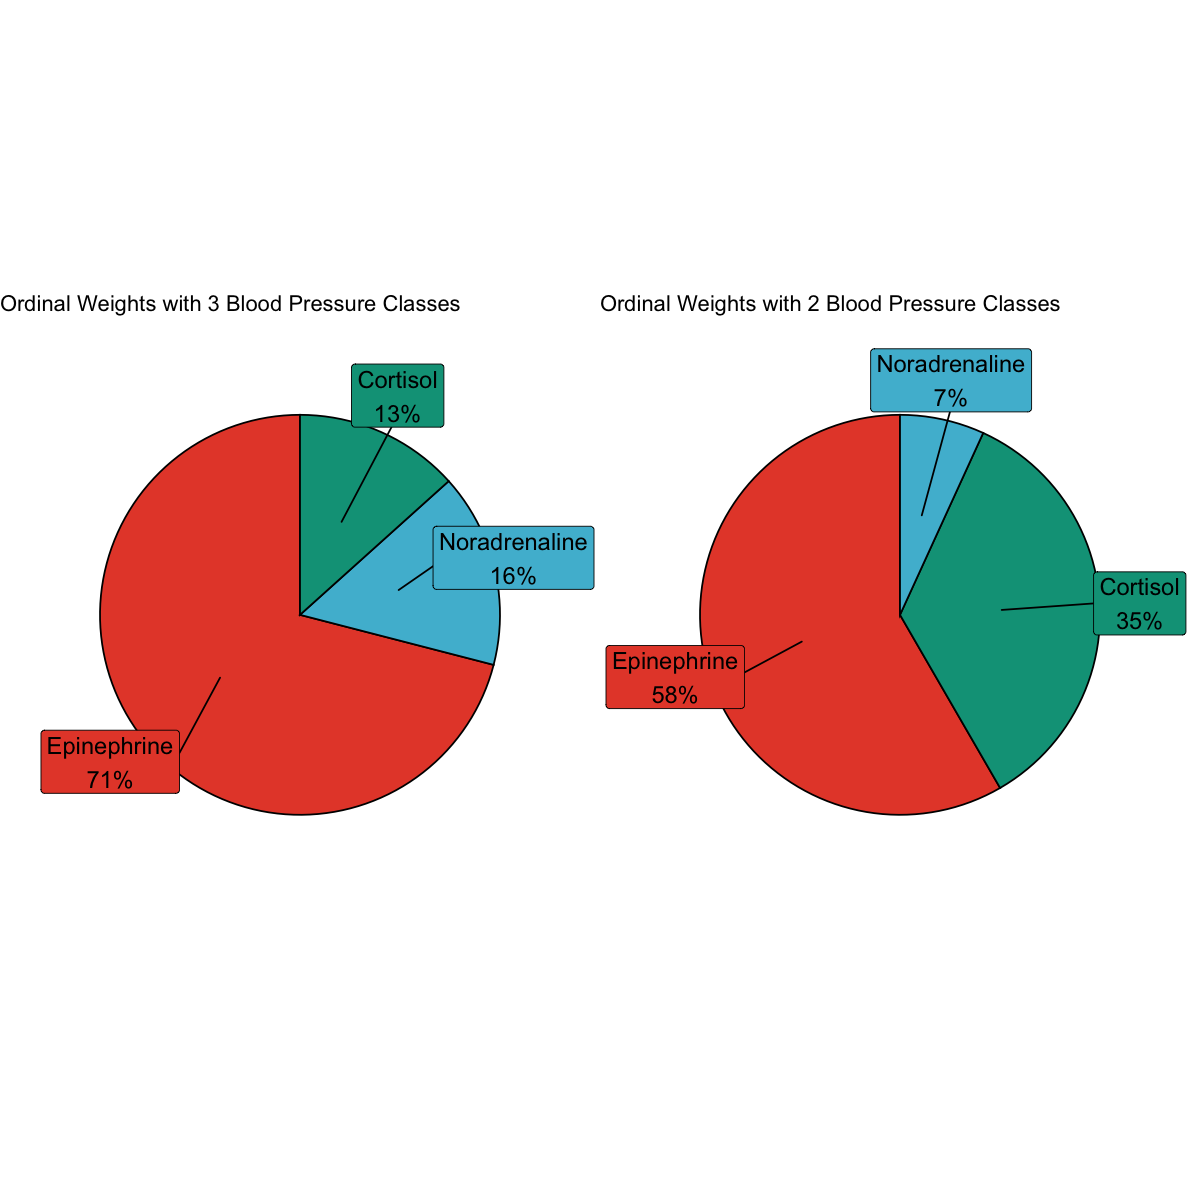

In [16]:
plot_grid(piechart3, piechart2)

Based on these results, epinephrine had the largest contribution to blood pressure classification in both cases. 

## Acute Stress Summation

Now that we have these weights from the ordinal regression, we'll calculate stress scores for each subject using both the previously calculated mediator scores multiplied the ordinal weight for the 3 acute biomarkers (cortisol, noradrenaline, epinephrine). AL scores will be calculated for all 63 subjects not just the 34 with BP data. The formula looks like...

Allostatic Load = Cortisol ordinal weight * Cortisol score + Epinephrine ordinal weight * Epinephrine score...

In [17]:
acute_stress = function(weights_df){
    # add words!!
    
    # combining the mediator scores for all 63 subjects with the ordinal weights into one dataframe
    wider_weights_df = mediator_scores_df %>%
        filter(Variable %in% acute_biomarkers) %>%
        mutate(Mediator_Score = log2(Mediator_Score + 1)) %>%
        dcast(Variable ~ Subject_ID, value.var = "Mediator_Score") %>% 
        inner_join(weights_df) %>%
        column_to_rownames("Variable")

    # multiplying the value of the mediator in each row by its respective ordinal
    # weight found in the last column
    multiplication_df = wider_weights_df %>%
        dplyr::select(-Coefficient) %>%
        mutate(across(contains("_"), ~.x*wider_weights_df$Coefficient))

    # calculating allostatic load by summing by the columns
    allostatic_load_df = data.frame(Acute_Stress = apply(multiplication_df, 2, sum)) %>%
        arrange(-Acute_Stress) %>%
        rownames_to_column(var = "Subject_ID")
    
    return(allostatic_load_df)
    }

# calling fn
three_acute_stress_df = acute_stress(three_weights_df)
two_acute_stress_df = acute_stress(two_weights_df)

head(three_acute_stress_df)

Joining with `by = join_by(Variable)`
Joining with `by = join_by(Variable)`


,Subject_ID,Acute_Stress
,<chr>,<dbl>
1,NS_M_28_W_51,0.8069382
2,NS_F_23_W_41,0.5635610
3,CS_M_28_W_16,0.5400870
4,NS_F_21_W_38,0.5112396
5,CS_M_29_W_17,0.4616988
6,NS_F_38_B_61,0.4394047


# Chronic Stress Summation

This involves normalizing their mediator scores, multiplying HDL by -1 since it's considered protective against atherosclerotic risk, and summing them to get the chronic stress score.

These biomarkers are essentially weighted with 1 or -1.

In [18]:
chronic_biomarkers = c('Hba1c','CRP', 'HDL','Fibrinogen')

chronic_stress_df = mediator_scores_df %>%
    # filtering for chronic biomarkers
    filter(Variable %in% chronic_biomarkers) %>%
    # normalizing
    mutate(Mediator_Score = log2(Mediator_Score + 1)) %>%
    # making HDL negative
    mutate(Mediator_Score = ifelse(Variable == "HDL", Mediator_Score * -1, Mediator_Score)) %>%
    # summing for each subject
    group_by(Subject_ID) %>%
    summarize(Summed_Score = sum(Mediator_Score)) %>%
    # rescaling so that these numbers fall between 0 and 1
    mutate(Chronic_Stress = (Summed_Score  - min(Summed_Score))/ (max(Summed_Score) - min(Summed_Score))) %>%
    dplyr::select(-Summed_Score) %>%
    arrange(-Chronic_Stress)

head(chronic_stress_df)

Subject_ID,Chronic_Stress
<chr>,<dbl>
NS_F_42_B_62,1.0000000
CS_F_39_W_32,0.8849612
NS_F_28_B_53,0.8810224
NS_F_35_B_59,0.8382134
NS_F_27_B_50,0.8268365
NS_F_23_W_41,0.7215899


# Overall AL

Summing the acute and chronic stress scores. These scores range from 0-2.

In [19]:
allostatic_three_df = inner_join(three_acute_stress_df, chronic_stress_df) %>%
    mutate(Allostatic_Load = Acute_Stress + Chronic_Stress)

allostatic_two_df = inner_join(two_acute_stress_df, chronic_stress_df) %>%
    mutate(Allostatic_Load = Acute_Stress + Chronic_Stress)

head(allostatic_three_df)

Joining with `by = join_by(Subject_ID)`
Joining with `by = join_by(Subject_ID)`


,Subject_ID,Acute_Stress,Chronic_Stress,Allostatic_Load
,<chr>,<dbl>,<dbl>,<dbl>
1,NS_M_28_W_51,0.8069382,0.09677053,0.9037087
2,NS_F_23_W_41,0.5635610,0.72158988,1.2851509
3,CS_M_28_W_16,0.5400870,0.32974467,0.8698317
4,NS_F_21_W_38,0.5112396,0.51026534,1.0215049
5,CS_M_29_W_17,0.4616988,0.38316708,0.8448658
6,NS_F_38_B_61,0.4394047,0.64381800,1.0832227


Before testing for statistical differences, let's check the ANOVA assumptions: normality and homogeneity of variance.

In [20]:
# seeing if this data is normal
do.call(rbind.data.frame, apply(allostatic_three_df[,2:4], 2, shapiro.test))[,1:3] %>%
    mutate(Normality = ifelse(p.value < 0.05, "Non-normal", "Normal"))

do.call(rbind.data.frame, apply(allostatic_two_df[,2:4], 2, shapiro.test))[,1:3] %>%
    mutate(Normality = ifelse(p.value < 0.05, "Non-normal", "Normal"))

,statistic,p.value,method,Normality
,<dbl>,<dbl>,<chr>,<chr>
Acute_Stress,0.9145401,0.0003314206,Shapiro-Wilk normality test,Non-normal
Chronic_Stress,0.9517668,0.0150754390,Shapiro-Wilk normality test,Non-normal
Allostatic_Load,0.9521905,0.0158159192,Shapiro-Wilk normality test,Non-normal


,statistic,p.value,method,Normality
,<dbl>,<dbl>,<chr>,<chr>
Acute_Stress,0.9295009,0.00140166,Shapiro-Wilk normality test,Non-normal
Chronic_Stress,0.9517668,0.01507544,Shapiro-Wilk normality test,Non-normal
Allostatic_Load,0.9556824,0.02356695,Shapiro-Wilk normality test,Non-normal


These data aren't normally distributed. However, I'm moving forward and creating the dataframe necessary to run the variance tests and anova tests.

In [21]:
# adding in demographic info for each subject
three_anova_df = inner_join(allostatic_three_df, subject_info_df[,c(3,5,6,8)])
two_anova_df = inner_join(allostatic_two_df, subject_info_df[,c(3,5,6,8)])


# converting into factors
three_anova_df$Smoking_Status = factor(three_anova_df$Smoking_Status, levels = c("NS", "CS"))
three_anova_df$Sex = factor(three_anova_df$Sex, levels = c("M", "F"))
three_anova_df$Race = factor(three_anova_df$Race, levels = c("W", "B"))
two_anova_df$Smoking_Status = factor(two_anova_df$Smoking_Status, levels = c("NS", "CS"))
two_anova_df$Sex = factor(two_anova_df$Sex, levels = c("M", "F"))
two_anova_df$Race = factor(two_anova_df$Race, levels = c("W", "B"))

head(three_anova_df)

Joining with `by = join_by(Subject_ID)`
Joining with `by = join_by(Subject_ID)`


,Subject_ID,Acute_Stress,Chronic_Stress,Allostatic_Load,Smoking_Status,Sex,Race
,<chr>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<fct>
1,NS_M_28_W_51,0.8069382,0.09677053,0.9037087,NS,M,W
2,NS_F_23_W_41,0.5635610,0.72158988,1.2851509,NS,F,W
3,CS_M_28_W_16,0.5400870,0.32974467,0.8698317,CS,M,W
4,NS_F_21_W_38,0.5112396,0.51026534,1.0215049,NS,F,W
5,CS_M_29_W_17,0.4616988,0.38316708,0.8448658,CS,M,W
6,NS_F_38_B_61,0.4394047,0.64381800,1.0832227,NS,F,B


Using a levene's test to assess homogeneity of variance.

In [29]:
leveneTest(Allostatic_Load ~ Sex, data = three_anova_df)[1,3]
leveneTest(Allostatic_Load ~ Race, data = three_anova_df)[1,3]
leveneTest(Allostatic_Load ~ Smoking_Status, data = three_anova_df)[1,3]
leveneTest(Allostatic_Load ~ Sex, data = two_anova_df)[1,3]
leveneTest(Allostatic_Load ~ Race, data = two_anova_df)[1,3]
leveneTest(Allostatic_Load ~ Smoking_Status, data = two_anova_df)[1,3]
leveneTest(Allostatic_Load ~ Sex * Smoking_Status, data = three_anova_df)[1,3]
leveneTest(Allostatic_Load ~ Race * Sex, data = three_anova_df)[1,3]
leveneTest(Allostatic_Load ~ Smoking_Status * Race, data = three_anova_df)[1,3]
leveneTest(Allostatic_Load ~ Sex * Smoking_Status, data = two_anova_df)[1,3]
leveneTest(Allostatic_Load ~ Race * Sex, data = two_anova_df)[1,3]
leveneTest(Allostatic_Load ~ Smoking_Status * Race, data = two_anova_df)[1,3]

[1] 0.0495203

[1] 0.8838901

[1] 0.008354611

[1] 0.0211607

[1] 0.9132512

[1] 0.01046151

[1] 0.01970261

[1] 0.5534546

[1] 0.4715878

[1] 0.02540485

[1] 0.5467832

[1] 0.5434425

There are differences in variances for sex, smoking status, as well as the interaction betwen sex and smoking status.

In [22]:
# looking at counts for each variable
# smoking status
table(three_anova_df[,c(5)])
chisq.test(table(three_anova_df[,c(5)]))
# sex
table(three_anova_df[,c(6)])
chisq.test(table(three_anova_df[,c(6)]))
# race
table(three_anova_df[,c(7)])
chisq.test(table(three_anova_df[,c(7)]))
# smoking status and sex
table(three_anova_df[,c(5:6)])
chisq.test(table(three_anova_df[,c(5:6)]))
# smoking status and race
table(three_anova_df[,c(5,7)])
chisq.test(table(three_anova_df[,c(5,7)]))
# race and sex
table(three_anova_df[,c(6:7)])
chisq.test(table(three_anova_df[,c(6:7)]))


NS CS 
30 33 


	Chi-squared test for given probabilities

data:  table(three_anova_df[, c(5)])
X-squared = 0.14286, df = 1, p-value = 0.7055



 M  F 
23 40 


	Chi-squared test for given probabilities

data:  table(three_anova_df[, c(6)])
X-squared = 4.5873, df = 1, p-value = 0.03221



 W  B 
32 31 


	Chi-squared test for given probabilities

data:  table(three_anova_df[, c(7)])
X-squared = 0.015873, df = 1, p-value = 0.8997


              Sex
Smoking_Status  M  F
            NS  7 23
            CS 16 17


	Pearson's Chi-squared test with Yates' continuity correction

data:  table(three_anova_df[, c(5:6)])
X-squared = 3.2722, df = 1, p-value = 0.07046


              Race
Smoking_Status  W  B
            NS 16 14
            CS 16 17


	Pearson's Chi-squared test with Yates' continuity correction

data:  table(three_anova_df[, c(5, 7)])
X-squared = 0.017465, df = 1, p-value = 0.8949


   Race
Sex  W  B
  M 12 11
  F 20 20


	Pearson's Chi-squared test with Yates' continuity correction

data:  table(three_anova_df[, c(6:7)])
X-squared = 5.4891e-31, df = 1, p-value = 1


Although there are significant differences in sex therefore, it's clear that our dataset underrepresents non-smoking men.

# Statistical Tests of AL and Stress Scores
Now testing for statistical differences based on sex, race, and smoking status using a two way anova and the tukey's post hoc tests. A type III Anova will be used, since we're interested in the interaction terms and the data is unbalanced. 

Type II is best when there's no interaction. Both type I and II are best when the data is balanced [ref](https://md.psych.bio.uni-goettingen.de/mv/unit/lm_cat/lm_cat_unbal_ss_explained.html).  Therefore a type III anova will be used.

## Allostatic Load

In [33]:
get_anova = function(anova_df, variable1, variable2, outcome, bp_class){
    # add words!!
    # creating a function to run an anova

    # runing anova
    anova_results = aov(eval(rlang::parse_expr(outcome)) ~ eval(rlang::parse_expr(variable1)) * eval(rlang::parse_expr(variable2)), 
                        data = anova_df) 
    
    # type 3 anova
    anova_type3 = Anova(anova_results, type = 'III', contrasts = list(topic = contr.sum, sys = contr.sum))

    # extract f and p values
    anova_summary = anova_type3[2:4,3:4]
    colnames(anova_summary) = c("F_Value", "P_Value")

    # creating df to be exported
    anova_values = data.frame(Outcome = outcome, BP_Class = bp_class, 
                              Comparison = c(variable1, variable2, paste(variable1, ":", variable2)), anova_summary)
    # removing row names
    rownames(anova_values) = NULL
                
    return(anova_values)
                
    }

In [34]:
# calling fn
three_anova_smoking_race_AL = get_anova(three_anova_df, 'Smoking_Status', 'Race', 'Allostatic_Load', "Three")
three_anova_smoking_sex_AL = get_anova(three_anova_df, 'Smoking_Status', 'Sex', 'Allostatic_Load', "Three")
three_anova_sex_race_AL = get_anova(three_anova_df, 'Sex', 'Race', 'Allostatic_Load', "Three")
two_anova_smoking_race_AL = get_anova(two_anova_df, 'Smoking_Status', 'Race', 'Allostatic_Load', "Two")
two_anova_smoking_sex_AL = get_anova(two_anova_df, 'Smoking_Status', 'Sex', 'Allostatic_Load', "Two")
two_anova_sex_race_AL = get_anova(two_anova_df, 'Sex', 'Race', 'Allostatic_Load', "Two")

# creating 1 df
allostatic_anova_df = unique(rbind(three_anova_smoking_race_AL, three_anova_smoking_sex_AL,
                            three_anova_sex_race_AL, two_anova_smoking_race_AL, two_anova_smoking_sex_AL,
                            two_anova_smoking_race_AL, two_anova_sex_race_AL)) #%>%
    # only need results from interactions
    #filter(grepl(":", Comparison))

In [35]:
# viewing sig results
allostatic_anova_df %>%
    filter(P_Value < 0.1)

Outcome,BP_Class,Comparison,F_Value,P_Value
<chr>,<chr>,<chr>,<dbl>,<dbl>
Allostatic_Load,Three,Race,5.679911,0.020398427
Allostatic_Load,Three,Sex,5.813981,0.019031417
Allostatic_Load,Three,Sex : Race,9.856932,0.002642525
Allostatic_Load,Two,Race,6.613339,0.012661308
Allostatic_Load,Two,Smoking_Status : Race,2.850442,0.096628388
Allostatic_Load,Two,Sex,3.197740,0.078875060
Allostatic_Load,Two,Sex : Race,7.404330,0.008538073


In [36]:
# ADD WORDS
three_anova_df = three_anova_df %>%
    unite(`Smoking_Status:Race`, Smoking_Status, Race, sep = ":", remove = FALSE) %>%
    unite(`Race:Sex`, Race, Sex, sep = ":", remove = FALSE) %>%
    unite(`Sex:Smoking_Status`, Sex, Smoking_Status, sep = ":", remove = FALSE)

two_anova_df = two_anova_df %>%
    unite(`Smoking_Status:Race`, Smoking_Status, Race, sep = ":", remove = FALSE) %>%
    unite(`Race:Sex`, Race, Sex, sep = ":", remove = FALSE) %>%
    unite(`Sex:Smoking_Status`, Sex, Smoking_Status, sep = ":", remove = FALSE)

head(three_anova_df)

,Subject_ID,Acute_Stress,Chronic_Stress,Allostatic_Load,Smoking_Status:Race,Sex:Smoking_Status,Smoking_Status,Race:Sex,Sex,Race
,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<fct>,<chr>,<fct>,<fct>
1,NS_M_28_W_51,0.8069382,0.09677053,0.9037087,NS:W,M:NS,NS,W:M,M,W
2,NS_F_23_W_41,0.5635610,0.72158988,1.2851509,NS:W,F:NS,NS,W:F,F,W
3,CS_M_28_W_16,0.5400870,0.32974467,0.8698317,CS:W,M:CS,CS,W:M,M,W
4,NS_F_21_W_38,0.5112396,0.51026534,1.0215049,NS:W,F:NS,NS,W:F,F,W
5,CS_M_29_W_17,0.4616988,0.38316708,0.8448658,CS:W,M:CS,CS,W:M,M,W
6,NS_F_38_B_61,0.4394047,0.64381800,1.0832227,NS:B,F:NS,NS,B:F,F,B


In [37]:
t_test_output = function(anova_df, variable1, interaction, outcome, bp_class){
    # add words!!
    # creating a function to run tukeys tests
    
    # t test for 1 variable
    t_test = t.test(formula(paste(outcome, "~", variable1)), anova_df)
    t_test_values = data.frame(Interaction = NA, Variable1 = variable1, Variable2 = NA, 
                               Difference = t_test$estimate[[2]] - t_test$estimate[[1]], P_Value = t_test$p.value, P_Adj = NA)
    
    # pairwise t test
    pairwise_t_test = pairwise.t.test(anova_df[[outcome]], anova_df[[interaction]], p.adj = 'none')
    pairwise_p_value_df = data.frame(pairwise_t_test$p.value) %>%
        rownames_to_column(var = "group1") %>%
        melt(variable.name = "group2", value.name = "P_Value") %>%
        drop_na() %>%
        mutate(P_Adj = p.adjust(as.numeric(as.character(P_Value)), method = "fdr")) %>%
        mutate(group2 = gsub("\\.", ":", as.character(group2)))

    # obtaining absolute differences between the groups
    Difference = c()
    for (i in 1:length(pairwise_p_value_df$group1)){

        group1_df = anova_df %>%
            filter(eval(rlang::parse_expr(interaction)) == pairwise_p_value_df$group1[i])

       group2_df = anova_df %>%
            filter(eval(rlang::parse_expr(interaction)) == pairwise_p_value_df$group2[i])

        mean_diff = mean(group2_df[[outcome]]) - mean(group1_df[[outcome]])
        Difference = c(Difference, mean_diff)
        }
    
    pairwise_values = cbind(pairwise_p_value_df, Interaction = interaction, Difference)

    # reordering and renaming
    colnames(pairwise_values)[c(1:2)] = c("Variable1", "Variable2")
    pairwise_values = pairwise_values[c(5,1:2,6,3,4)]

    # creating df to be exported
    tukey_values = data.frame(Outcome = outcome, BP_Class = bp_class, 
                              rbind(t_test_values, pairwise_values))
                              
    

    return(tukey_values)
}

# calling fn
three_t_test_smoking_race_AL = t_test_output(three_anova_df, 'Smoking_Status', 'Smoking_Status:Race', 'Allostatic_Load', "Three")
three_t_test_smoking_sex_AL = t_test_output(three_anova_df, 'Sex', 'Sex:Smoking_Status', 'Allostatic_Load', "Three")
three_t_test_sex_race_AL = t_test_output(three_anova_df, 'Race', 'Race:Sex', 'Allostatic_Load', "Three")
two_t_test_smoking_race_AL = t_test_output(two_anova_df, 'Smoking_Status', 'Smoking_Status:Race', 'Allostatic_Load', "Two")
two_t_test_smoking_sex_AL = t_test_output(two_anova_df, 'Sex', 'Sex:Smoking_Status', 'Allostatic_Load',  "Two")
two_t_test_sex_race_AL = t_test_output(two_anova_df, 'Race', 'Race:Sex', 'Allostatic_Load', "Two")

# creating 1 df
allostatic_t_test_df = unique(rbind(three_t_test_smoking_race_AL, three_t_test_smoking_sex_AL,
                            three_t_test_sex_race_AL, two_t_test_smoking_race_AL, two_t_test_smoking_sex_AL,
                            two_t_test_sex_race_AL)) 

Using group1 as id variables

Using group1 as id variables

Using group1 as id variables

Using group1 as id variables

Using group1 as id variables

Using group1 as id variables



In [38]:
# viewing sig results
allostatic_t_test_df %>%
    # only need results from single variables
    filter(!grepl(":", Variable1) & P_Value < 0.1) 

# interaction/pairwise results
allostatic_t_test_df %>%
    filter(grepl(":", Variable1) & P_Adj < 0.1)

Outcome,BP_Class,Interaction,Variable1,Variable2,Difference,P_Value,P_Adj
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
Allostatic_Load,Three,NA,Race,NA,0.1282970,0.09483115,NA
Allostatic_Load,Two,NA,Race,NA,0.1321555,0.07589869,NA


Outcome,BP_Class,Interaction,Variable1,Variable2,Difference,P_Value,P_Adj
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
Allostatic_Load,Three,Smoking_Status:Race,NS:B,CS:B,-0.2470506,0.022293925,0.044587850
Allostatic_Load,Three,Smoking_Status:Race,NS:B,CS:W,-0.2731844,0.013063538,0.044587850
Allostatic_Load,Three,Smoking_Status:Race,NS:W,NS:B,0.2543682,0.020398427,0.044587850
Allostatic_Load,Three,Race:Sex,B:M,B:F,0.2154843,0.046409965,0.092819931
Allostatic_Load,Three,Race:Sex,W:F,B:F,0.2979211,0.001461714,0.008770283
Allostatic_Load,Three,Race:Sex,W:M,W:F,-0.2484320,0.019031417,0.057094251
Allostatic_Load,Two,Smoking_Status:Race,NS:B,CS:B,-0.2529730,0.015289839,0.030579677
Allostatic_Load,Two,Smoking_Status:Race,NS:B,CS:W,-0.2777036,0.008925812,0.030579677
Allostatic_Load,Two,Smoking_Status:Race,NS:W,NS:B,0.2640616,0.012661308,0.030579677


There are statistically significant differences in allostatic load based on race, and the interaction between race and sex using ordinal weights from blood pressure classification with three classes.

Only race was significant when using ordinal weights from blood pressure classification with two classes. CHANGE!!!

Now visualizing sig comparisons, but only for the 3 class ordinal weights since it had more significant comparisons.

## Race & Sex Boxplot

In [39]:
# plotting t test values instead of tukey's since
# it gives me both the p values and adjusted p values
t_test_p_values_AL_race_sex = compare_means(Allostatic_Load ~ Race:Sex, data = three_anova_df, 
                                         method = "t.test", p.adjust.method = 'fdr') %>%
    # basing the p.signif off of adjusted p values
    mutate(p.signif = ifelse(p.adj < 0.0001, '****', 
                             ifelse(p.adj >= 0.0001 & p.adj < 0.001, '***',
                                   ifelse(p.adj >= 0.001 & p.adj < 0.01, '**',
                                         ifelse(p.adj >= 0.01 & p.adj < 0.05, '*', 
                                                ifelse(p.adj >= 0.05 & p.adj < 0.1, '.', 
                                                    'ns')))))) %>%
    # manually adding the y position
    mutate(y.position = c(1.4, 1, 1, 1.6, 1, 1.4))

t_test_p_values_AL_race_sex

.y.,group1,group2,p,p.adj,p.format,p.signif,method,y.position
<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>
Allostatic_Load,W:M,W:F,0.01283778,0.039,0.0128,*,T-test,1.4
Allostatic_Load,W:M,B:F,0.60244164,0.600,0.6024,ns,T-test,1.0
Allostatic_Load,W:M,B:M,0.10483932,0.160,0.1048,ns,T-test,1.0
Allostatic_Load,W:F,B:F,0.00383513,0.023,0.0038,*,T-test,1.6
Allostatic_Load,W:F,B:M,0.41956423,0.500,0.4196,ns,T-test,1.0
Allostatic_Load,B:F,B:M,0.04244168,0.085,0.0424,.,T-test,1.4


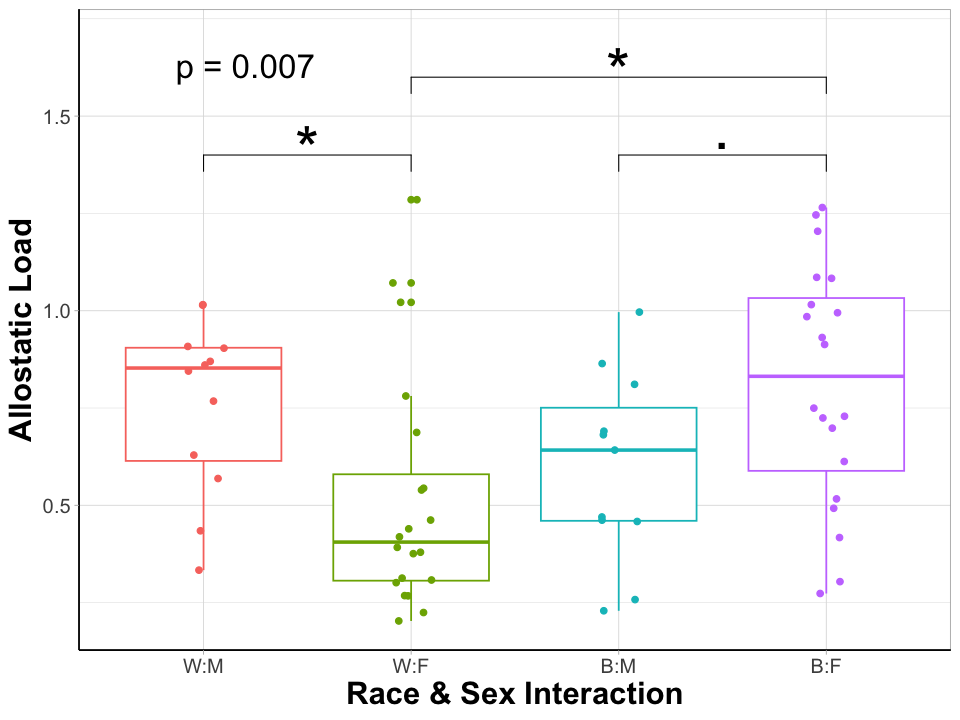

In [40]:
options(repr.plot.width=8, repr.plot.height=6) #changing size

fig1 = ggplot(data = three_anova_df, aes(x = Race:Sex, y = Allostatic_Load, color = Race:Sex)) + 
  geom_boxplot() + 
  geom_point(position = position_jitter(w = 0.1)) + 
  ylim(NA, 1.7) + # adding more space for p value significance

  # overall anova p value
  stat_anova_test(wid = "Race:Sex", p.adjust.method = "none", label = "p = {p.format}", 
                     label.x.npc = "left", size = 7, label.y = 1.6) +

  # adjusted p value
  stat_pvalue_manual(t_test_p_values_AL_race_sex %>%
                         filter(p.signif != 'ns'), label = "p.signif", size = 13) + 

theme_light() + 
  theme(axis.line = element_line(colour = "black"), #making x and y axes black
        axis.text = element_text(size = 12), #changing size of x axis labels
        legend.position = 'none', # removes legend
        axis.title = element_text(face = "bold", size = rel(1.7))) + #changes axis titles
         
  labs(x = 'Race & Sex Interaction', y = 'Allostatic Load')  #changing axis labels 

fig1

### Smoking Status & Race Boxplot

In [41]:
# plotting t test values instead of tukey's since
# it gives me both the p values and adjusted p values
t_test_p_values_AL_smoking_race = compare_means(Allostatic_Load ~ Smoking_Status:Race, data = three_anova_df, 
                                         method = "t.test", p.adjust.method = 'fdr') %>%
    # basing the p.signif off of adjusted p values
    mutate(p.signif = ifelse(p.adj < 0.0001, '****', 
                             ifelse(p.adj >= 0.0001 & p.adj < 0.001, '***',
                                   ifelse(p.adj >= 0.001 & p.adj < 0.01, '**',
                                         ifelse(p.adj >= 0.01 & p.adj < 0.05, '*', 
                                                ifelse(p.adj >= 0.05 & p.adj < 0.1, '.', 
                                                    'ns')))))) %>%
    # manually adding the y position
    mutate(y.position = c(1, 1.4, 1, 1.7, 1, 1.5))

t_test_p_values_AL_smoking_race

.y.,group1,group2,p,p.adj,p.format,p.signif,method,y.position
<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>
Allostatic_Load,NS:W,CS:W,0.86211990,0.940,0.862,ns,T-test,1.0
Allostatic_Load,NS:W,NS:B,0.04614376,0.092,0.046,.,T-test,1.4
Allostatic_Load,NS:W,CS:B,0.93862052,0.940,0.939,ns,T-test,1.0
Allostatic_Load,CS:W,NS:B,0.02808936,0.087,0.028,.,T-test,1.7
Allostatic_Load,CS:W,CS:B,0.77000156,0.940,0.770,ns,T-test,1.0
Allostatic_Load,NS:B,CS:B,0.02909349,0.087,0.029,.,T-test,1.5


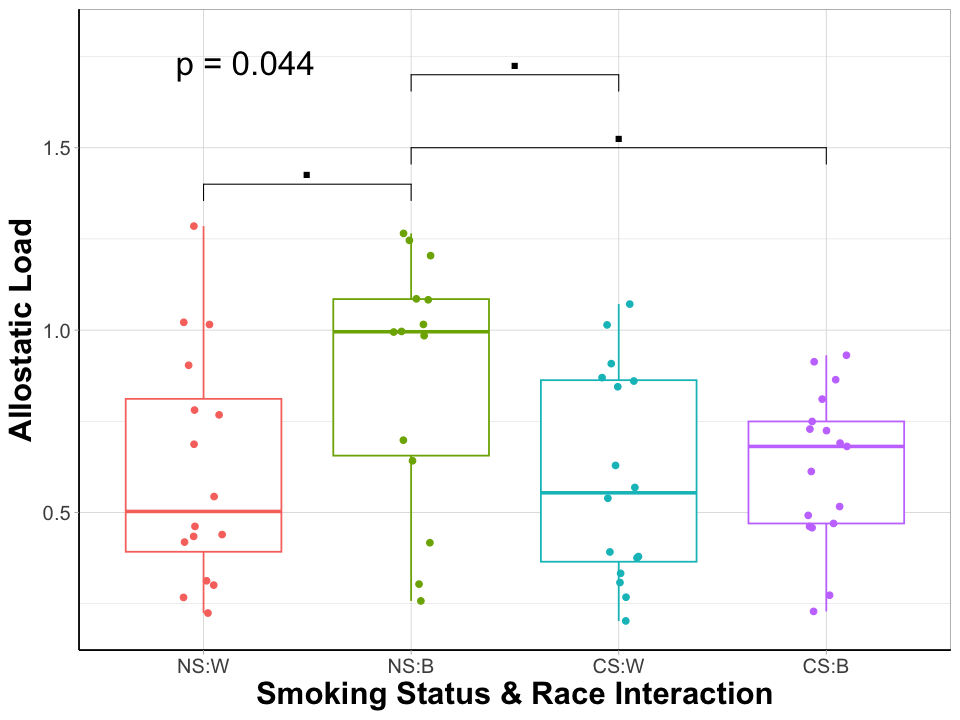

In [42]:
fig2 = ggplot(data = three_anova_df, aes(x = Smoking_Status:Race, y = Allostatic_Load, color = Smoking_Status:Race)) + 
  geom_boxplot() + 
  geom_point(position = position_jitter(w = 0.1)) + 
  ylim(NA, 1.8) + # adding more space for p value significance

  # overall anova p value
  stat_anova_test(wid = "Smoking_Status:Race", p.adjust.method = "none", label = "p = {p.format}", 
                     label.x.npc = "left", size = 7, label.y = 1.7) +

  # adjusted p value
  stat_pvalue_manual(t_test_p_values_AL_smoking_race %>%
                         filter(p.signif != 'ns'), label = "p.signif", size = 13) + 

  theme_light() + 
  theme(axis.line = element_line(colour = "black"), #making x and y axes black
        axis.text = element_text(size = 12), #changing size of x axis labels
        legend.position = 'none', # removes legend
        axis.title = element_text(face = "bold", size = rel(1.7))) + #changes axis titles
         
  labs(x = 'Smoking Status & Race Interaction', y = 'Allostatic Load')  #changing axis labels 

fig2

## Acute Stress

In [43]:
# calling anova fn
three_anova_smoking_race_acute = get_anova(three_anova_df, 'Smoking_Status', 'Race', 'Acute_Stress', "Three")
three_anova_smoking_sex_acute = get_anova(three_anova_df, 'Sex', 'Smoking_Status', 'Acute_Stress', "Three")
three_anova_sex_race_acute = get_anova(three_anova_df, 'Sex', 'Race', 'Acute_Stress', "Three")
two_anova_smoking_race_acute = get_anova(two_anova_df, 'Smoking_Status', 'Race', 'Acute_Stress', "Two")
two_anova_smoking_sex_acute = get_anova(two_anova_df, 'Sex', 'Smoking_Status', 'Acute_Stress', "Two")
two_anova_sex_race_acute = get_anova(two_anova_df, 'Sex', 'Race', 'Acute_Stress', "Two")

# creating 1 df
acute_anova_df = unique(rbind(three_anova_smoking_race_acute, three_anova_smoking_sex_acute,
                            three_anova_sex_race_acute, two_anova_smoking_race_acute, 
                              two_anova_smoking_sex_acute, two_anova_sex_race_acute)) %>%
    # only need results from interactions
    filter(grepl(":", Comparison))

In [44]:
# viewing sig results
acute_anova_df %>%
    filter(P_Value < 0.1)

Outcome,BP_Class,Comparison,F_Value,P_Value
<chr>,<chr>,<chr>,<dbl>,<dbl>
Acute_Stress,Three,Sex : Race,6.574596,0.01291096


In [57]:
# calling fn
three_t_test_smoking_race_acute = t_test_output(three_anova_df, 'Smoking_Status', 'Smoking_Status:Race', 'Acute_Stress', "Three")
three_t_test_smoking_sex_acute = t_test_output(three_anova_df, 'Sex', 'Sex:Smoking_Status', 'Acute_Stress', "Three")
three_t_test_sex_race_acute = t_test_output(three_anova_df, 'Race', 'Race:Sex', 'Acute_Stress', "Three")
two_t_test_smoking_race_acute = t_test_output(two_anova_df, 'Smoking_Status', 'Smoking_Status:Race', 'Acute_Stress', "Two")
two_t_test_smoking_sex_acute = t_test_output(two_anova_df, 'Sex', 'Sex:Smoking_Status', 'Acute_Stress',  "Two")
two_t_test_sex_race_acute = t_test_output(two_anova_df, 'Race', 'Race:Sex', 'Acute_Stress', "Two")

# creating 1 df
acute_t_test_df = unique(rbind(three_t_test_smoking_race_acute, three_t_test_smoking_sex_acute,
                            three_t_test_sex_race_acute, two_t_test_smoking_race_acute, 
                            two_t_test_smoking_sex_acute, two_t_test_sex_race_acute))

Using group1 as id variables

Using group1 as id variables

Using group1 as id variables

Using group1 as id variables

Using group1 as id variables

Using group1 as id variables



In [58]:
# viewing sig results
acute_t_test_df %>%
    # only need results from single variables
    filter(!grepl(":", Variable1) & P_Value < 0.1) 

# interaction/pairwise results
acute_t_test_df %>%
    filter(grepl(":", Variable1) & P_Adj < 0.1)

Outcome,BP_Class,Interaction,Variable1,Variable2,Difference,P_Value,P_Adj
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
Acute_Stress,Three,NA,Smoking_Status,NA,-0.06945255,0.05087630,NA
Acute_Stress,Two,NA,Smoking_Status,NA,-0.06952480,0.03570467,NA


Outcome,BP_Class,Interaction,Variable1,Variable2,Difference,P_Value,P_Adj
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
Acute_Stress,Three,Sex:Smoking_Status,F:NS,F:CS,-0.09801911,0.024333177,0.07299953
Acute_Stress,Three,Sex:Smoking_Status,M:NS,F:CS,-0.15691188,0.010728981,0.06437389
Acute_Stress,Three,Race:Sex,W:M,B:F,-0.10149045,0.039462609,0.07892522
Acute_Stress,Three,Race:Sex,W:M,B:M,-0.14106353,0.013025666,0.03907700
Acute_Stress,Three,Race:Sex,W:M,W:F,-0.13763563,0.005912095,0.03547257


There are statistically significant differences in acute stress based on race, sex, and the interaction between race and sex using ordinal weights from blood pressure classification with three classes.

There are statistically significant differences in acute stress between non-smokers and cigarette smokers (p value = 0.02). The interaction between sex and race was significant when using the ordinal weights derived from the 3 class BP prediction. Tukey's post hoc tests revealed that white males have a lower acute stress than white females (p adj < 0.05).?????

### Race & Sex Boxplot

In [37]:
# plotting t test values instead of tukey's since
# it gives me both the p values and adjusted p values
t_test_p_values_acute_race_sex = compare_means(Acute_Stress ~ Race:Sex, data = three_anova_df, 
                                         method = "t.test", p.adjust.method = 'fdr') %>%
    # basing the p.signif off of adjusted p values
    mutate(p.signif = ifelse(p.adj < 0.0001, '****', 
                             ifelse(p.adj >= 0.0001 & p.adj < 0.001, '***',
                                   ifelse(p.adj >= 0.001 & p.adj < 0.01, '**',
                                         ifelse(p.adj >= 0.01 & p.adj < 0.05, '*', 
                                                ifelse(p.adj >= 0.05 & p.adj < 0.1, '.', 
                                                    'ns')))))) %>%
    # manually adding the y position
    mutate(y.position = c(1.4, 1, 1.6, 1, 1, 1))

t_test_p_values_acute_race_sex

.y.,group1,group2,p,p.adj,p.format,p.signif,method,y.position
<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>
Acute_Stress,W:M,W:F,0.03099272,0.093,0.031,.,T-test,1.4
Acute_Stress,W:M,B:F,0.09862810,0.200,0.099,ns,T-test,1.0
Acute_Stress,W:M,B:M,0.02554288,0.093,0.026,.,T-test,1.6
Acute_Stress,W:F,B:F,0.37195378,0.450,0.372,ns,T-test,1.0
Acute_Stress,W:F,B:M,0.93021694,0.930,0.930,ns,T-test,1.0
Acute_Stress,B:F,B:M,0.30403489,0.450,0.304,ns,T-test,1.0


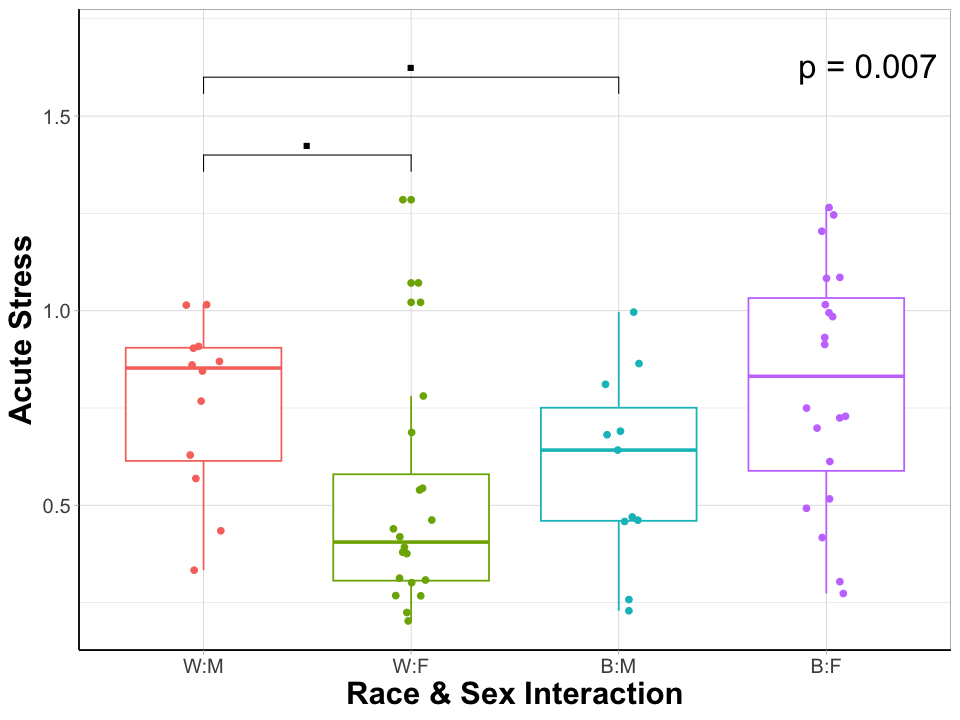

In [38]:
fig3 = ggplot(data = three_anova_df, aes(x = Race:Sex, y = Allostatic_Load, color = Race:Sex)) + 
  geom_boxplot() + 
  geom_point(position = position_jitter(w = 0.1)) + 
  ylim(NA, 1.7) + # adding more space for p value significance

  # overall anova p value
  stat_anova_test(wid = "Race:Sex", p.adjust.method = "none", label = "p = {p.format}", 
                     label.x.npc = "right", size = 7, label.y = 1.6) +

  # adjusted p value
  stat_pvalue_manual(t_test_p_values_acute_race_sex %>%
                         filter(p.signif != 'ns'), label = "p.signif", size = 13) + 

  theme_light() + 
  theme(axis.line = element_line(colour = "black"), #making x and y axes black
        axis.text = element_text(size = 12), #changing size of x axis labels
        legend.position = 'none', # removes legend
        axis.title = element_text(face = "bold", size = rel(1.7))) + #changes axis titles
         
  labs(x = 'Race & Sex Interaction', y = 'Acute Stress')  #changing axis labels 

fig3

### Smoking Status & Sex Boxplot

In [39]:
t_test_p_values_acute_smoking_sex = compare_means(Acute_Stress ~ Sex:Smoking_Status, data = three_anova_df, 
                                         method = "t.test", p.adjust.method = 'fdr') %>%
    # basing the p.signif off of adjusted p values
    mutate(p.signif = ifelse(p.adj < 0.0001, '****', 
                             ifelse(p.adj >= 0.0001 & p.adj < 0.001, '***',
                                   ifelse(p.adj >= 0.001 & p.adj < 0.01, '**',
                                         ifelse(p.adj >= 0.01 & p.adj < 0.05, '*', 
                                                ifelse(p.adj >= 0.05 & p.adj < 0.1, '.', 
                                                    'ns')))))) %>%
    # manually adding the y position
    mutate(y.position = c(1, 1, 1, 1, 0.7, 0.9))

t_test_p_values_acute_smoking_sex

.y.,group1,group2,p,p.adj,p.format,p.signif,method,y.position
<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>
Acute_Stress,M:NS,F:NS,0.535800092,0.640,0.5358,ns,T-test,1.0
Acute_Stress,M:NS,M:CS,0.467262038,0.640,0.4673,ns,T-test,1.0
Acute_Stress,M:NS,F:CS,0.122467410,0.240,0.1225,ns,T-test,1.0
Acute_Stress,F:NS,M:CS,0.790013727,0.790,0.7900,ns,T-test,1.0
Acute_Stress,F:NS,F:CS,0.008948007,0.054,0.0089,.,T-test,0.7
Acute_Stress,M:CS,F:CS,0.022352212,0.067,0.0224,.,T-test,0.9


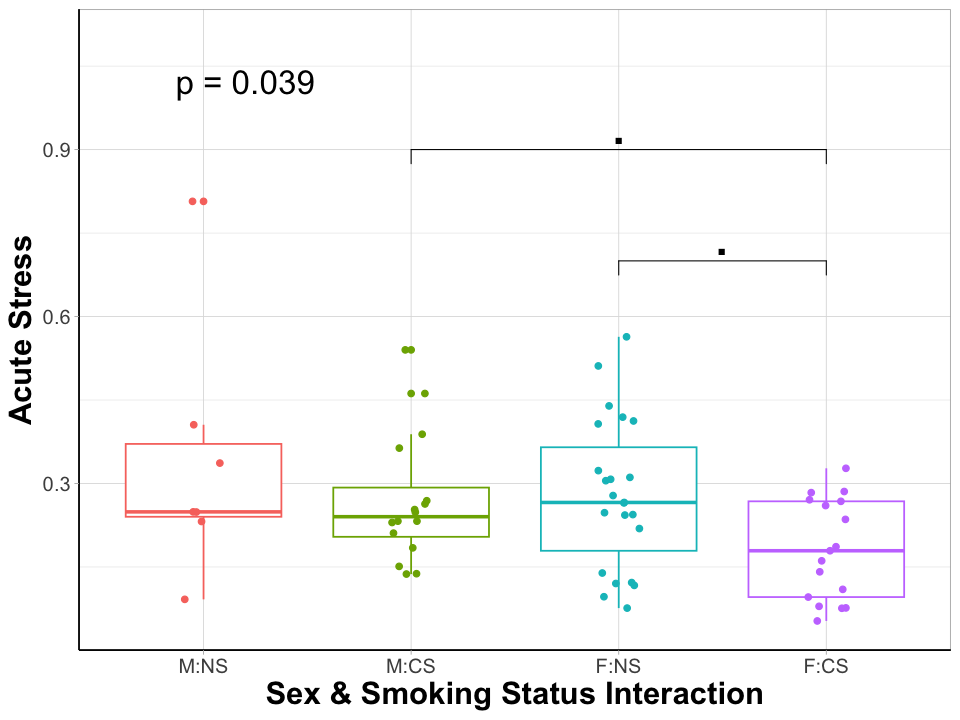

In [40]:
fig4 = ggplot(data = three_anova_df, aes(x = Sex:Smoking_Status, y = Acute_Stress, color = Sex:Smoking_Status)) + 
  geom_boxplot() + 
  geom_point(position = position_jitter(w = 0.1)) + 

  # adding more space for p value significance
  ylim(NA, 1.1) + 

  # overall anova p value
  stat_anova_test(wid = "Sex:Smoking_Status", p.adjust.method = "none", label = "p = {p.format}", 
                     label.x.npc = "left", size = 7, label.y = 1) +

  # adjusted p value
  stat_pvalue_manual(t_test_p_values_acute_smoking_sex %>%
                         filter(p.signif != 'ns'), label = "p.signif", size = 13) + 

theme_light() + 
  theme(axis.line = element_line(colour = "black"), #making x and y axes black
        axis.text = element_text(size = 12), #changing size of x axis labels
        legend.position = 'none', # removes legend
        axis.title = element_text(face = "bold", size = rel(1.7))) + #changes axis titles
         
  labs(x = 'Sex & Smoking Status Interaction', y = 'Acute Stress')  #changing axis labels 

fig4

## Chronic Stress

In [41]:
# calling anova fn
anova_smoking_race_chronic = get_anova(three_anova_df, 'Smoking_Status', 'Race', 'Chronic_Stress', NA)
anova_smoking_sex_chronic = get_anova(three_anova_df, 'Smoking_Status', 'Sex', 'Chronic_Stress', NA)
anova_sex_race_chronic = get_anova(three_anova_df, 'Sex', 'Race', 'Chronic_Stress', NA)

# creating 1 df
chronic_anova_df = unique(rbind(anova_smoking_race_chronic, anova_smoking_sex_chronic,
                            anova_sex_race_chronic)) %>%
    # only need results from interactions
    filter(grepl(":", Comparison))

In [42]:
# viewing sig results
chronic_anova_df %>%
    filter(P_Value < 0.1)

Outcome,BP_Class,Comparison,F_Value,P_Value
<chr>,<chr>,<chr>,<dbl>,<dbl>
Chronic_Stress,Three,Race,9.560772,0.003033896
Chronic_Stress,Three,Sex : Race,5.808469,0.019085653


ADD WORDS

In [43]:
# calling fn
t_test_smoking_race_chronic = t_test_output(three_anova_df, 'Smoking_Status', 'Smoking_Status:Race', 'Chronic_Stress', NA)
t_test_smoking_sex_chronic = t_test_output(three_anova_df, 'Sex', 'Sex:Smoking_Status', 'Chronic_Stress', NA)
t_test_sex_race_chronic = t_test_output(three_anova_df, 'Race', 'Race:Sex', 'Chronic_Stress', NA)

# creating 1 df
chronic_t_test_df = unique(rbind(t_test_smoking_race_chronic, t_test_smoking_sex_chronic, t_test_sex_race_chronic))

Using group1 as id variables

Using group1 as id variables

Using group1 as id variables



In [44]:
# viewing sig results
chronic_t_test_df %>%
    # only need results from single variables
    filter(!grepl(":", Variable1) & P_Value < 0.1) 

# interaction/pairwise results
chronic_t_test_df %>%
    filter(grepl(":", Variable1) & P_Adj < 0.1)

Outcome,BP_Class,Interaction,Variable1,Variable2,Difference,P_Value,P_Adj
<chr>,<lgl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
Chronic_Stress,NA,NA,Race,NA,0.1578072,0.009811123,NA


Outcome,BP_Class,Interaction,Variable1,Variable2,Difference,P_Value,P_Adj
<chr>,<lgl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
Chronic_Stress,NA,Smoking_Status:Race,NS:B,CS:W,-0.2299423,0.0085897288,0.025769186
Chronic_Stress,NA,Smoking_Status:Race,NS:W,NS:B,0.2615060,0.0030338956,0.018203374
Chronic_Stress,NA,Race:Sex,W:F,B:F,0.2617760,0.0005680924,0.003408555


There are statistically significant differences in chronic allostatic load (stress) based on race (p value = 0.03). The interaction between sex and race was significant (p value < 0.01). 

Tukey's post hoc tests revealed that white females have a higher chronic AL than black females (p adj < 0.05).?

### Race & Sex Boxplot

In [45]:
# plotting t test values instead of tukey's since
# it gives me both the p values and adjusted p values
t_test_p_values_chronic_race_sex = compare_means(Chronic_Stress ~ Race:Sex, data = three_anova_df, 
                                         method = "t.test", p.adjust.method = 'fdr') %>%
    # basing the p.signif off of adjusted p values
    mutate(p.signif = ifelse(p.adj < 0.0001, '****', 
                             ifelse(p.adj >= 0.0001 & p.adj < 0.001, '***',
                                   ifelse(p.adj >= 0.001 & p.adj < 0.01, '**',
                                         ifelse(p.adj >= 0.01 & p.adj < 0.05, '*', 
                                                ifelse(p.adj >= 0.05 & p.adj < 0.1, '.', 
                                                    'ns')))))) %>%
    # manually adding the y position
    mutate(y.position = c(1, 1, 1, 1.3, 1, 1))

t_test_p_values_chronic_race_sex

.y.,group1,group2,p,p.adj,p.format,p.signif,method,y.position
<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>
Chronic_Stress,W:M,W:F,0.166445263,0.2500,0.1664,ns,T-test,1.0
Chronic_Stress,W:M,B:F,0.064645064,0.1300,0.0646,ns,T-test,1.0
Chronic_Stress,W:M,B:M,0.770877232,0.7700,0.7709,ns,T-test,1.0
Chronic_Stress,W:F,B:F,0.001389908,0.0083,0.0014,**,T-test,1.3
Chronic_Stress,W:F,B:M,0.306787309,0.3700,0.3068,ns,T-test,1.0
Chronic_Stress,B:F,B:M,0.043933900,0.1300,0.0439,ns,T-test,1.0


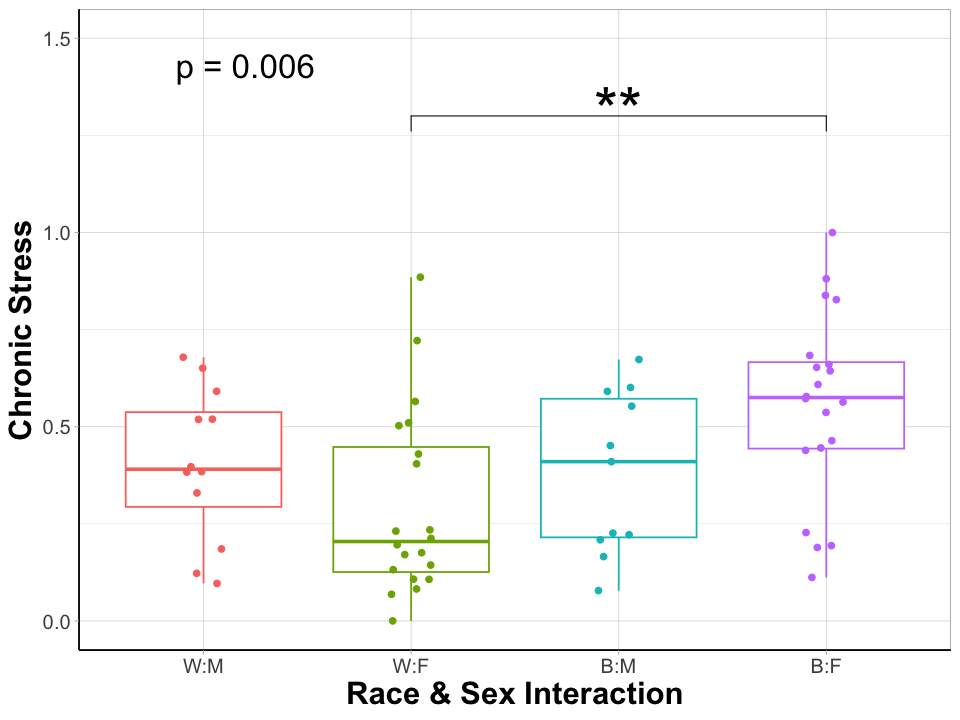

In [47]:
fig5 = ggplot(data = three_anova_df, aes(x = Race:Sex, y = Chronic_Stress, color = Race:Sex)) + 
  geom_boxplot() + 
  geom_point(position = position_jitter(w = 0.1)) + 
  ylim(NA, 1.5) + # adding more space for p value significance

  # overall anova p value
  stat_anova_test(wid = "Race:Sex", p.adjust.method = "none", label = "p = {p.format}", 
                     label.x.npc = "left", size = 7, label.y = 1.4) +

  # adjusted p value
  stat_pvalue_manual(t_test_p_values_chronic_race_sex %>%
                         filter(p.signif != 'ns'), label = "p.signif", size = 13) + 

  theme_light() + 
  theme(axis.line = element_line(colour = "black"), #making x and y axes black
        axis.text = element_text(size = 12), #changing size of x axis labels
        legend.position = 'none', # removes legend
        axis.title = element_text(face = "bold", size = rel(1.7))) + #changes axis titles
         
  labs(x = 'Race & Sex Interaction', y = 'Chronic Stress')  #changing axis labels 

fig5

### Smoking Status & Race Boxplot

In [48]:
t_test_p_values_chronic_smoking_race = compare_means(Chronic_Stress ~ Smoking_Status:Race, data = three_anova_df, 
                                         method = "t.test", p.adjust.method = 'fdr') %>%
    # basing the p.signif off of adjusted p values
    mutate(p.signif = ifelse(p.adj < 0.0001, '****', 
                             ifelse(p.adj >= 0.0001 & p.adj < 0.001, '***',
                                   ifelse(p.adj >= 0.001 & p.adj < 0.01, '**',
                                         ifelse(p.adj >= 0.01 & p.adj < 0.05, '*', 
                                                ifelse(p.adj >= 0.05 & p.adj < 0.1, '.', 
                                                    'ns')))))) %>%
    # manually adding the y position
    mutate(y.position = c(1, 1.1, 1, 1.3, 1, 1))

t_test_p_values_chronic_smoking_race

.y.,group1,group2,p,p.adj,p.format,p.signif,method,y.position
<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>
Chronic_Stress,NS:W,CS:W,0.700892880,0.700,0.7009,ns,T-test,1.0
Chronic_Stress,NS:W,NS:B,0.008928662,0.054,0.0089,.,T-test,1.1
Chronic_Stress,NS:W,CS:B,0.184187749,0.280,0.1842,ns,T-test,1.0
Chronic_Stress,CS:W,NS:B,0.019778514,0.059,0.0198,.,T-test,1.3
Chronic_Stress,CS:W,CS:B,0.357782622,0.430,0.3578,ns,T-test,1.0
Chronic_Stress,NS:B,CS:B,0.076513737,0.150,0.0765,ns,T-test,1.0


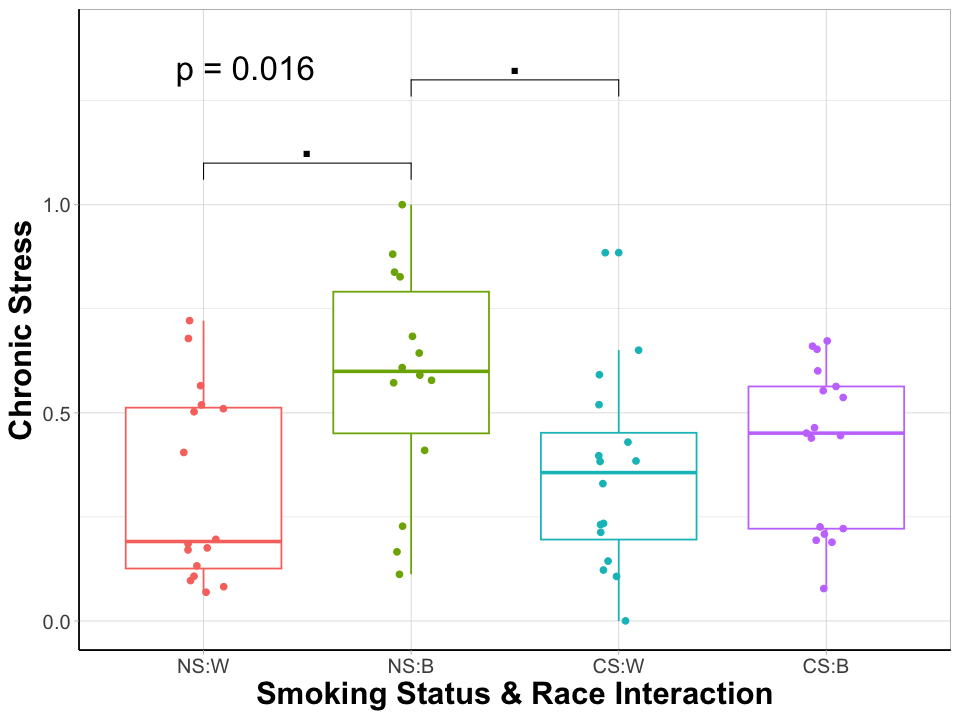

In [49]:
fig6 = ggplot(data = three_anova_df, aes(x = Smoking_Status:Race, y = Chronic_Stress, color = Smoking_Status:Race)) + 
  geom_boxplot() + 
  geom_point(position = position_jitter(w = 0.1)) + 

  # adding more space for p value significance
  ylim(NA, 1.4) + 

  # overall anova p value
  stat_anova_test(wid = "Smoking_Status:Race", p.adjust.method = "none", label = "p = {p.format}", 
                     label.x.npc = "left", size = 7, label.y = 1.3) +

  # adjusted p value
  stat_pvalue_manual(t_test_p_values_chronic_smoking_race %>%
                         filter(p.signif != 'ns'), label = "p.signif", size = 13) + 

theme_light() + 
  theme(axis.line = element_line(colour = "black"), #making x and y axes black
        axis.text = element_text(size = 12), #changing size of x axis labels
        legend.position = 'none', # removes legend
        axis.title = element_text(face = "bold", size = rel(1.7))) + #changes axis titles
         
  labs(x = 'Smoking Status & Race Interaction', y = 'Chronic Stress')  #changing axis labels 

fig6

# Recap of Significant Results
**Overall AL**
+ *Interaction of Sex and Race*
    + black females have a higher AL than white females
    + Putting Fibrinogen into the chronic stress allowed the two-way anova to pick up more potential significant associations including smoking status and race

**Acute Stress**
+ *Smoking Status*
    + non-smokers had higher acute stress than cigarette smokers
+ *Race*
    + Removing Fibrinogen made this significant, but only when using the 3 class ordinal weights
+ *Interaction of Sex and Race*
    + only significant when using the ordinal weights derived from the 3 class BP prediction
    + white females have a higher acute stress than white males

**Chronic Stress**
+ *Race*
  + black subjects have higher chronic stress than white subjects
  + Adding Fibrinogen made this even more significant
+ *Interaction of Sex and Race*
    + black females have a higher chronic stress than white females

In [50]:
t_test_boxplot_df = rbind(t_test_p_values_AL_smoking_race, t_test_p_values_AL_race_sex,
                              t_test_p_values_acute_smoking_sex, t_test_p_values_acute_race_sex,
                              t_test_p_values_chronic_smoking_race, t_test_p_values_chronic_race_sex)

head(t_test_boxplot_df)

.y.,group1,group2,p,p.adj,p.format,p.signif,method,y.position
<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>
Allostatic_Load,NS:W,CS:W,0.86211990,0.940,0.862,ns,T-test,1.0
Allostatic_Load,NS:W,NS:B,0.04614376,0.092,0.046,.,T-test,1.4
Allostatic_Load,NS:W,CS:B,0.93862052,0.940,0.939,ns,T-test,1.0
Allostatic_Load,CS:W,NS:B,0.02808936,0.087,0.028,.,T-test,1.7
Allostatic_Load,CS:W,CS:B,0.77000156,0.940,0.770,ns,T-test,1.0
Allostatic_Load,NS:B,CS:B,0.02909349,0.087,0.029,.,T-test,1.5


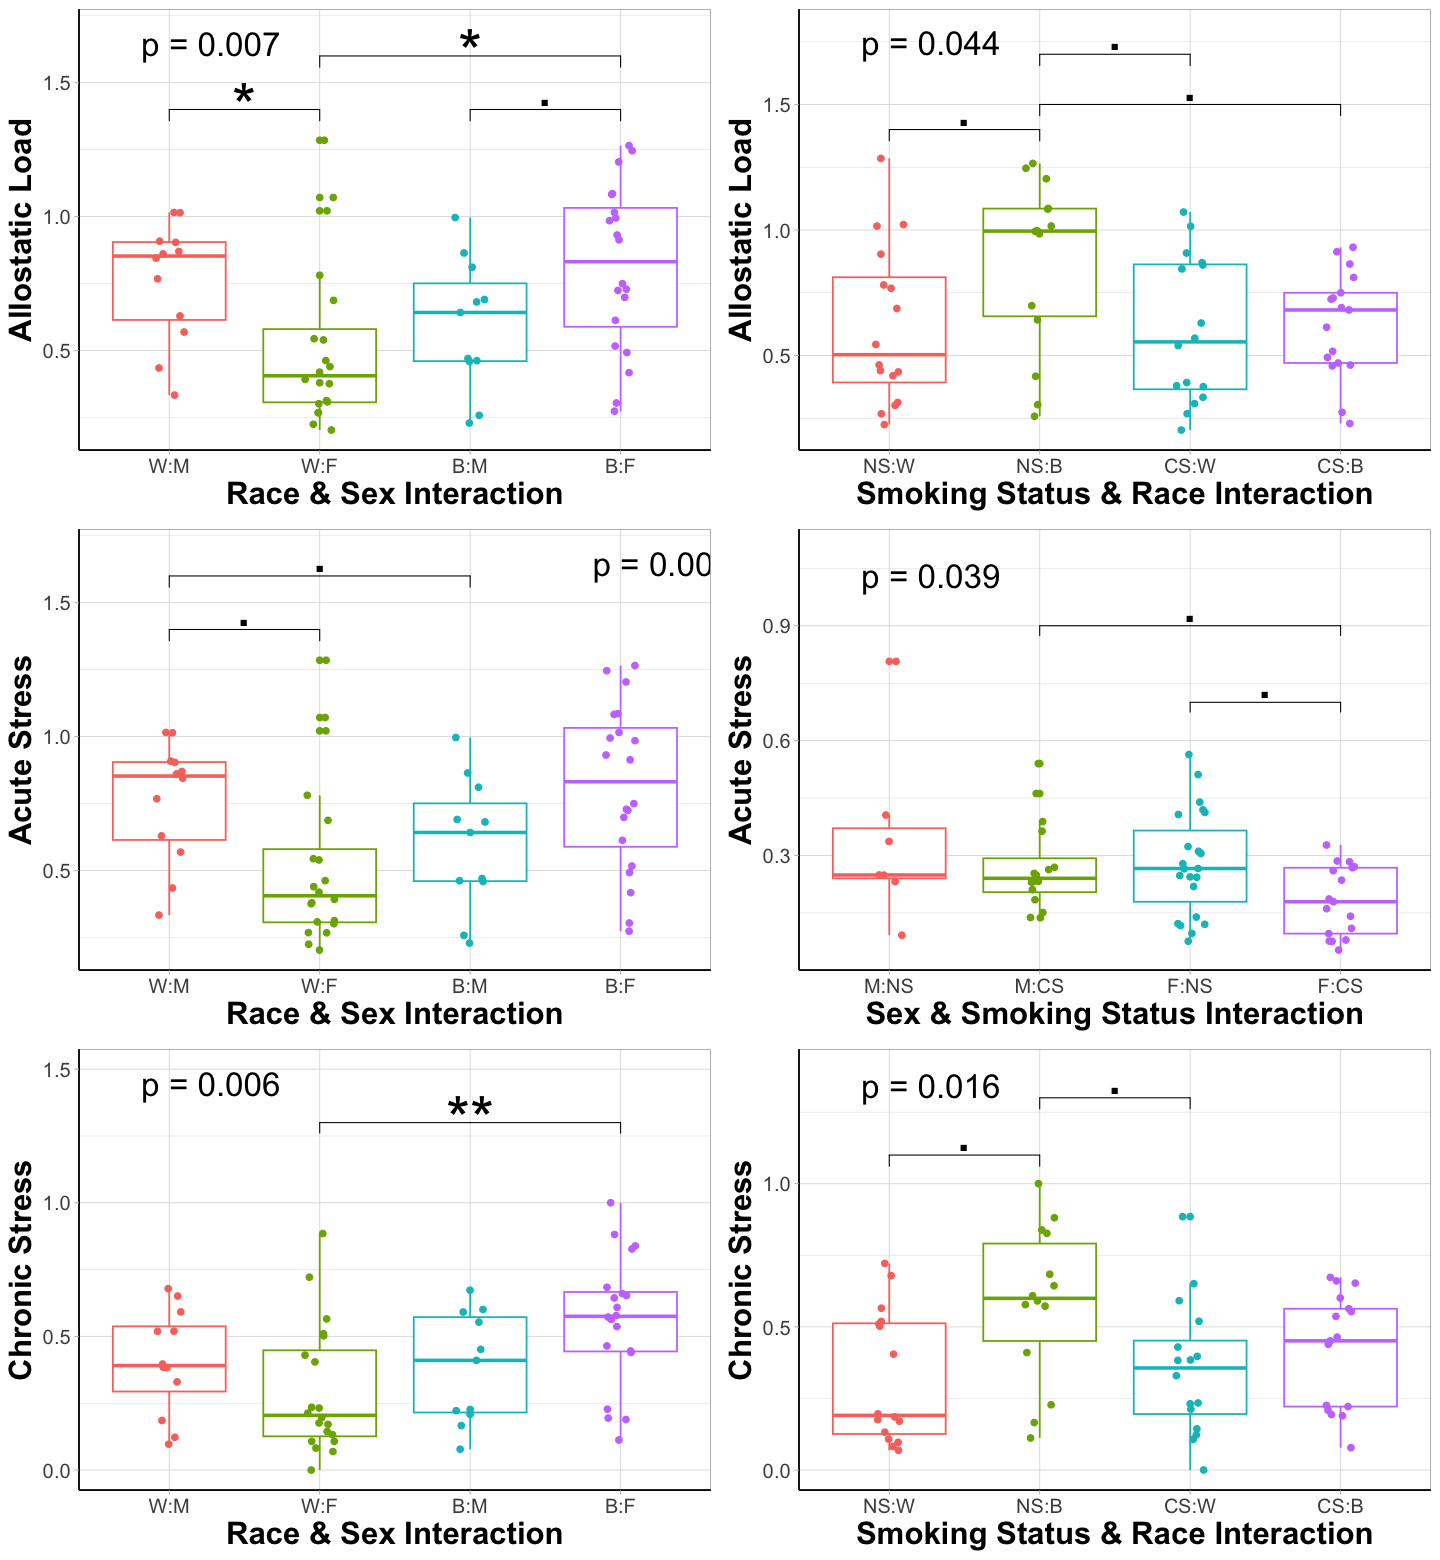

In [51]:
options(repr.plot.width = 12, repr.plot.height = 13) #changing size
plot_grid(fig1,fig2,fig3,fig4,fig5,fig6,
         ncol = 2)

In [52]:
# combining dfs for export
anova_dfs = rbind(allostatic_anova_df, acute_anova_df, chronic_anova_df)

head(anova_dfs)

,Outcome,BP_Class,Comparison,F_Value,P_Value
,<chr>,<chr>,<chr>,<dbl>,<dbl>
1,Allostatic_Load,Three,Smoking_Status,0.03330018,0.85582899
2,Allostatic_Load,Three,Race,5.67991067,0.02039843
3,Allostatic_Load,Three,Smoking_Status : Race,2.39928391,0.12673863
4,Allostatic_Load,Three,Smoking_Status,0.12422530,0.72575220
5,Allostatic_Load,Three,Sex,0.03453213,0.85321689
6,Allostatic_Load,Three,Smoking_Status : Sex,0.64831902,0.42394737


In [60]:
t_test_dfs = rbind(allostatic_t_test_df, acute_t_test_df, chronic_t_test_df)

head(t_test_dfs)

,Outcome,BP_Class,Interaction,Variable1,Variable2,Difference,P_Value,P_Adj
,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
1,Allostatic_Load,Three,NA,Smoking_Status,NA,-0.124058511,0.11330344,NA
2,Allostatic_Load,Three,Smoking_Status:Race,CS:W,CS:B,0.026133888,0.79787142,0.94281797
3,Allostatic_Load,Three,Smoking_Status:Race,NS:B,CS:B,-0.247050559,0.02229393,0.04458785
4,Allostatic_Load,Three,Smoking_Status:Race,NS:W,CS:B,0.007317612,0.94281797,0.94281797
5,Allostatic_Load,Three,Smoking_Status:Race,NS:B,CS:W,-0.273184448,0.01306354,0.04458785
6,Allostatic_Load,Three,Smoking_Status:Race,NS:W,CS:W,-0.018816277,0.85582899,0.94281797


In [61]:
# exporting
library(openxlsx)
write.xlsx(anova_dfs, paste0(Output,"/", "ANOVA_Results_", cur_date, ".xlsx"), rowNames = FALSE) 
write.xlsx(t_test_dfs, paste0(Output,"/", "T_test_Results_", cur_date, ".xlsx"), rowNames = FALSE) 